In [2]:
%load_ext rpy2.ipython

In [3]:
%%R
# loading R packages
library(plyr)
library(dplyr)
library(ggplot2)
library(tidyr)
library(phyloseq)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize

The following object is masked from ‘package:stats’:

    filter

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



In [4]:
%%R
physeq = import_biom("../data/otu_table_tax_no211_meta.biom", treefilename = "../data/ssu-aln.bacteria.mask.tre",
                    parseFunction = parse_taxonomy_greengenes)

In [5]:
%%R
l2fc<-read.csv("../data/l2fc.csv")

In [6]:
%%R
head(l2fc)

  Day Amdmt     OTU   baseMean        l2FC         SE    pvalue      padj
1   1     1  OTU.43  223.48048 -0.11012779 0.29052924 0.7046439 0.8990732
2   1     1   OTU.2 1664.01427  0.11095267 0.07837381 0.1568676 0.4569113
3   1     1 OTU.187  362.13258  0.06605159 0.15991481 0.6795756 0.8866206
4   1     1 OTU.150   39.05672  0.03205671 0.15816953 0.8393906 0.9496064
5   1     1  OTU.91   62.21140 -0.01718316 0.37497442 0.9634498 0.9886185
6   1     1 OTU.305   37.70726 -0.14629517 0.27103038 0.5893528 0.8405491


In [7]:
%%R
l2fc %>%
    group_by(OTU, Amdmt, Day) %>%
    summarize(N = n()) %>%
    arrange(desc(N)) %>%
    group_by() %>%
    head

Source: local data frame [6 x 4]

     OTU Amdmt Day N
1  OTU.1     1   1 1
2  OTU.1     1   2 1
3  OTU.1     2   1 1
4  OTU.1     2   2 1
5 OTU.10     1   1 1
6 OTU.10     1   2 1


In [8]:
%%R
d.plot = l2fc %>%
    select(OTU, Amdmt, Day, l2FC) %>%
    spread(Amdmt, l2FC)

In [9]:
%%R
colnames(d.plot) = c("OTU","Day","PyOM","Stover")

In [10]:
%%R
head(d.plot)

      OTU Day       PyOM     Stover
1   OTU.1   1  0.2054216  0.4771340
2   OTU.1   2 -0.1233362 -0.6062826
3  OTU.10   1  0.4884018  1.3051067
4  OTU.10   2  0.5907783  1.0979431
5 OTU.100   1  0.1624993  3.8479241
6 OTU.100   2 -0.3753782  0.6210347


In [11]:
%%R
pcollector1 = function (Day,OTU,PyOM){
    l2fc[l2fc$Day==Day & l2fc$OTU==OTU & l2fc$Amdmt==1,]$padj
}
pcollector2 = function (Day,OTU,Stover){
    l2fc[l2fc$Day==Day & l2fc$OTU==OTU & l2fc$Amdmt==2,]$padj
}
# Creating the functions to grab the adjusted p values, based on each day and OTUs

In [12]:
%%R
d.narm=d.plot[complete.cases(d.plot),]
dim(d.narm)
#Getting rid of the NAs, because that made the functions get confused.

[1] 7069    4


In [13]:
%%R
d.narm<-ddply(d.narm,c("Day","OTU"),transform, padjPyOM=pcollector1(Day,OTU),padjStover=pcollector2(Day,OTU))
head(d.narm)

       OTU Day        PyOM     Stover  padjPyOM   padjStover
1    OTU.1   1  0.20542160  0.4771340 0.5709752 1.720374e-01
2   OTU.10   1  0.48840184  1.3051067 0.1341594 5.782691e-06
3  OTU.100   1  0.16249933  3.8479241 0.8659611 1.648816e-11
4 OTU.1000   1 -0.05912125 -0.6842893 0.9293053 2.937055e-01
5 OTU.1001   1 -0.42946608 -1.1873493 0.5760887 2.117950e-01
6 OTU.1002   1 -0.18209508 -1.2019310 0.7622668 2.447503e-02


In [19]:
%%R
d.narm$pprod<-d.narm$padjPyOM*d.narm$padjStover

In [44]:
%%R
taxa<-data.frame(subset_taxa(tax_table(physeq)))
taxa$OTU<-row.names(taxa)
head(taxa)

In [50]:
%%R
taxonomycollector = function (OTU){
    taxa[taxa$OTU==OTU,1:8]
}

# Creating the functions to grab the taxonomy, based on each day and OTUs

In [52]:
%%R
d.mini<-d.narm[950:1000,]

In [54]:
%%R
d.narm.tax<-ddply(d.narm,"OTU",transform, taxonomy=taxonomycollector(OTU))
head(d.narm.tax)

      OTU Day       PyOM     Stover     padjPyOM   padjStover        pprod
1   OTU.1   1  0.2054216  0.4771340 0.5709752473 1.720374e-01 9.822909e-02
2   OTU.1   2 -0.1233362 -0.6062826 0.6511155845 1.987838e-04 1.294312e-04
3  OTU.10   1  0.4884018  1.3051067 0.1341593959 5.782691e-06 7.758024e-07
4  OTU.10   2  0.5907783  1.0979431 0.0003493384 6.731538e-08 2.351585e-11
5 OTU.100   1  0.1624993  3.8479241 0.8659610526 1.648816e-11 1.427811e-11
6 OTU.100   2 -0.3753782  0.6210347 0.3029378494 1.077858e-01 3.265239e-02
  taxonomy.Kingdom taxonomy.Phylum      taxonomy.Class   taxonomy.Order
1         Bacteria  Proteobacteria Alphaproteobacteria Sphingomonadales
2         Bacteria  Proteobacteria Alphaproteobacteria Sphingomonadales
3         Bacteria  Actinobacteria      Actinobacteria  Actinomycetales
4         Bacteria  Actinobacteria      Actinobacteria  Actinomycetales
5         Bacteria  Proteobacteria Alphaproteobacteria Sphingomonadales
6         Bacteria  Proteobacteria Alphapro

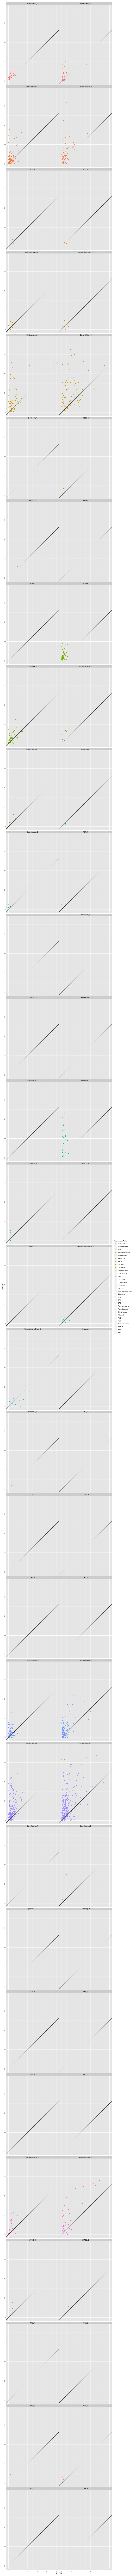

In [65]:
%%R -h 15000 -w 800
#p = ggplot(d.plot, aes(x = `1`, y =`2`))
p = ggplot(d.narm.tax, aes(x = PyOM, y =Stover, color=taxonomy.Phylum))
p = p + geom_point()
p = p + geom_abline(slope = 1, intercept = 0)
# p = p + geom_abline(x=2)
# p = p + stat_smooth(method = "lm")
p = p + facet_wrap(~taxonomy.Phylum~Day, ncol=2)
p = p + scale_x_continuous(limits = c(0, 5)) + scale_y_continuous(limits = c(0, 7.5))

p